# Import

In [1]:
%matplotlib inline

import os
import math
from pathlib import Path
from functools import partial
from inspect import isfunction

import cv2
import matplotlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops.layers.torch import Rearrange
from einops import rearrange, reduce, repeat
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

from utils import *
from unet import Unet
from data_loader import make_data_loader

# Parameters

In [2]:
device = 'cuda'
image_size = 64
batch_size = 128

channels = 1
unet_dim = 32
num_classes = 26
num_style = 100
timesteps = 1000
unet_dim_mults = (1, 2, 4, 8,)
model_path = './weight/log3_classifier_free_guidance_step_400000.pth'

# define betas
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# forward diffusion (using the nice property)
@autocast(enabled = False)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_sample(model, x, classes, style, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, classes, style, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, style, shape, class_scale=6., style_scale=6., rescaled_phi=0.7):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, classes, style, torch.full((b,), i, device=device, dtype=torch.long), i, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    return img

@torch.no_grad()
def sample(model, classes, style, image_size, batch_size=16, channels=3, class_scale=6., style_scale=6., rescaled_phi=0.7):
    return p_sample_loop(model, classes, style, shape=(batch_size, channels, image_size, image_size), class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

def imscatter(x,y,image_list,_ax=None,zoom=0.2,color=['black']):
    for i in range(len(image_list)):
        if len(color) < len(image_list):
            color.append(color[0])
        if _ax is None:
            _ax = plt.gca()
        image = image_list[i] #plt.imread(image_list[i])
        im = OffsetImage(image,zoom=zoom)
        artists = []
        x0 = x[i]
        y0 = y[i]
        ab = AnnotationBbox(im,(x0,y0),xycoords='data',frameon=True,bboxprops=dict(color=color[i]))
        artists.append(_ax.add_artist(ab))
    return artists

# データの読み込み

In [3]:
dataloader = make_data_loader(batch_size, image_size)['train']
d = dataloader.dataset

TRAIN SIZE: 2600
TEST SIZE: 0


In [ ]:
i = 26*4 + 23
d = dataloader.dataset
plt.imshow(d[i][0][0], cmap='gray')
c = chr(d[i][1] + ord('A'))
print(c)
print('style:', d[i][2])
print(d[i][0][0].min(), d[i][0][0].max())

In [ ]:
max_i = 0
for _, _, i in d['train'].dataset:
    max_i = max(max_i, i)
print(max_i)

# Load trained model

In [4]:
model = Unet(
    dim=unet_dim,
    channels=channels,
    dim_mults=unet_dim_mults,
    num_classes=num_classes,
    num_style=num_style,
    cond_drop_prob=0.5,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


Unet(
  (init_conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (classes_emb): Embedding(26, 32)
  (classes_mlp): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (style_emb): Embedding(100, 32)
  (style_mlp): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=64, bias=True)
        )
        (block1): Block(
          (proj): WeightStandar

# 生成画像のL1

In [ ]:
with open('result/eval.txt', 'a') as f:
    f.write('\n============\n')
    f.write(f"{model_path.split('/')[-1]}\n")

for scale in [3., 5., 7.]:
    style_scale = scale
    class_scale = scale
    rescaled_phi = 0.7

    loss = nn.L1Loss()
    total_loss = 0.

    for gt, c, s in dataloader:
        gt = gt.to(device)
        c = c.to(device)
        s = s.to(device)
        output = sample(model, c, s, image_size=image_size, batch_size=gt.size(0), channels=channels,
                        class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

        total_loss += loss(output, gt).item() * gt.size(0)

    total_loss /= len(dataloader.dataset)

    with open('result/eval.txt', 'a') as f:
        f.write(f'\tscale: {scale}, l1 loss: {total_loss}\n')

# condition指定して生成

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

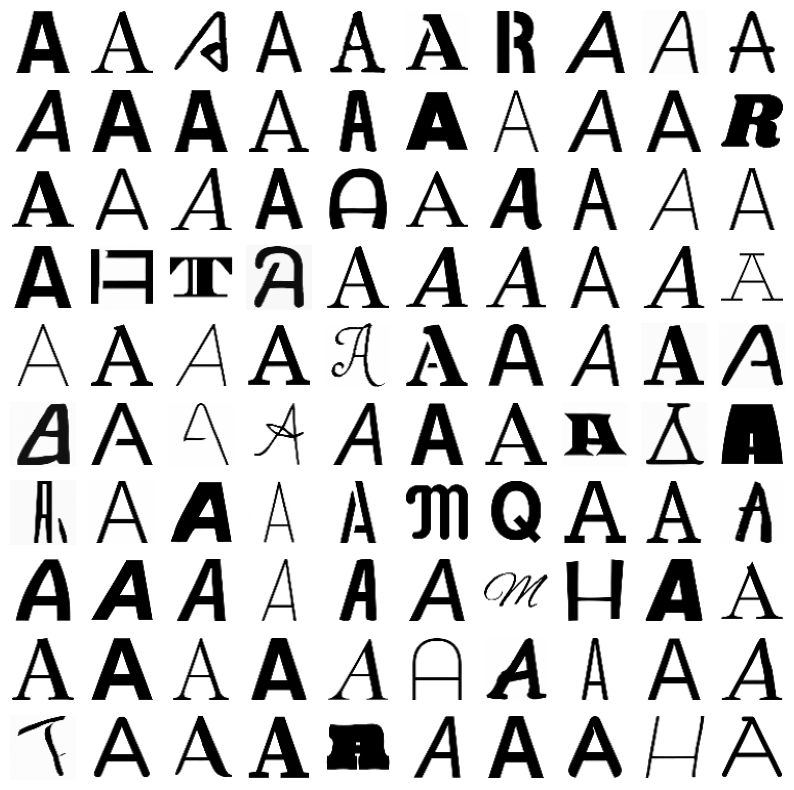

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

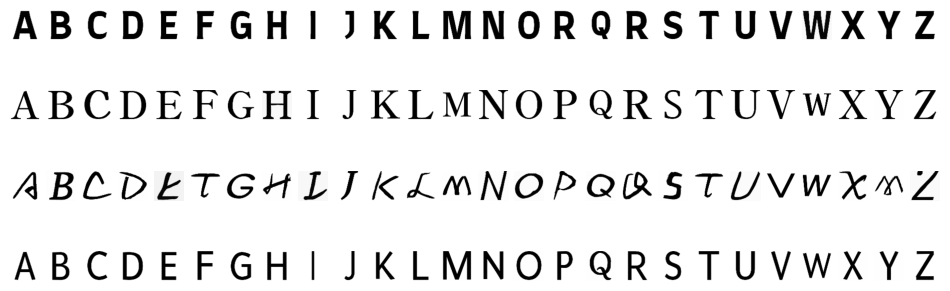

In [21]:

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

# 様々なスタイルを見る
b = 100
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([i for i in range(b)], device=device, dtype=torch.long)
samples = sample(model, classes, style, image_size=image_size, batch_size=b, channels=channels, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

# show images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(b):
    x = i // 10
    y = i % 10
    ax[x, y].axis("off")
    ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_generated1_{style_scale}_{class_scale}.png")
plt.show()

# 様々なクラスを見る
b = 26*4
classes = torch.tensor([i%26 for i in range(b)], device=device, dtype=torch.long)
style = torch.tensor([i//26 for i in range(b)], device=device, dtype=torch.long)
samples = sample(model, classes, style, image_size=image_size, batch_size=b, channels=channels, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

# show images
fig, ax = plt.subplots(4, 26, figsize=(12, 4))
for i in range(b):
    x = i // 26
    y = i % 26
    ax[x, y].axis("off")
    ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_generated2_{style_scale}_{class_scale}.png")
plt.show()

TRAIN SIZE: 25714
TEST SIZE: 0


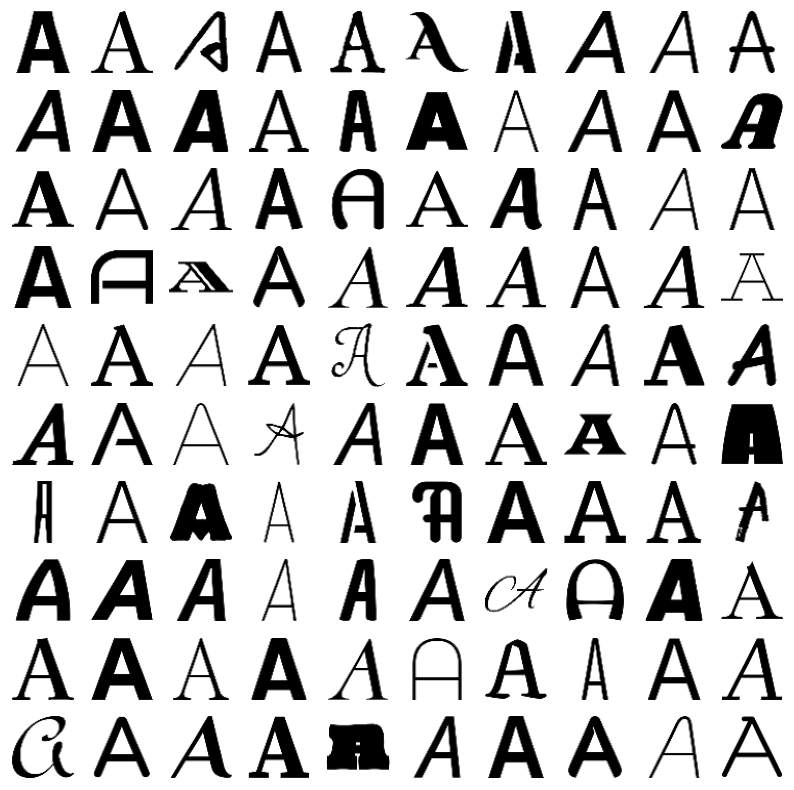

In [9]:
# 全Aデータを見る
d = make_data_loader(12, 64)['train'].dataset

fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[26*i][0][0], cmap='gray')

# ノイズのインターポレーション

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

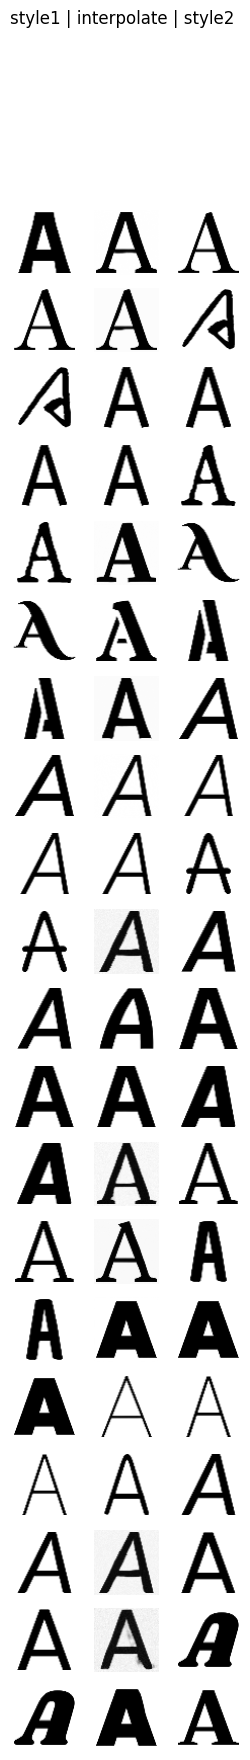

In [22]:
@torch.no_grad()
def p_sample_noise_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    pred_noise1 = model.forward_with_cond_scale(x, t, classes, style1, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    pred_noise2 = model.forward_with_cond_scale(x, t, classes, style2, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    alpha = 0.5
    pred_noise = alpha * pred_noise1 + (1 - alpha) * pred_noise2
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([[i, (i+1)%num_style] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_noise_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')
fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_{style_scale}_{class_scale}.png")

# 埋め込み表現のインターポレーション

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

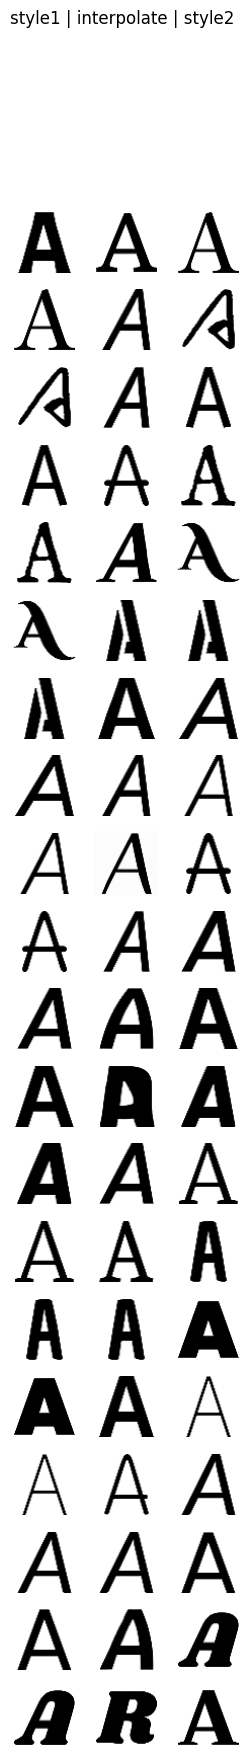

In [5]:
@torch.no_grad()
def p_sample_emb_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    pred_noise = model.emb_interpolate(x, t, classes, style1, style2, alpha=0.5)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([[i, (i+1)%num_style] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_emb_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')
fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_{style_scale}_{class_scale}.png")

# reconstruction

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

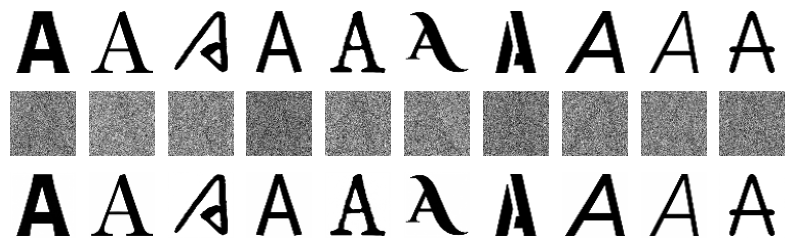

In [10]:
imgs = []
for i in range(10):
    imgs.append(d[26*i][0])
imgs = torch.stack(imgs).to(device)

sampling_t = int(0.90 * timesteps)
t = torch.full((10,), sampling_t, device=device, dtype=torch.long)
noisy_imgs = q_sample(imgs, t)

classes = torch.full((10,), 0, device=device, dtype=torch.long)
style = torch.tensor([i for i in range(10)], device=device, dtype=torch.long)
out = noisy_imgs
for i in tqdm(reversed(range(0, sampling_t)), desc='sampling loop time step', total=timesteps):
    out = p_sample(model, out, classes, style, torch.full((10,), i, device=device, dtype=torch.long), i, class_scale=6., style_scale=6., rescaled_phi=.7)

fig, ax = plt.subplots(3, 10, figsize=(10, 3))
for i in range(imgs.shape[0]):
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[0, i].imshow(imgs[i][0].cpu().detach(), cmap='gray')
    ax[1, i].imshow(noisy_imgs[i][0].cpu().detach(), cmap='gray')
    ax[2, i].imshow(out[i][0].cpu().detach(), cmap='gray')

# スタイル/クラス埋め込みの可視化

[0.08782574 0.06014738 0.05438238]


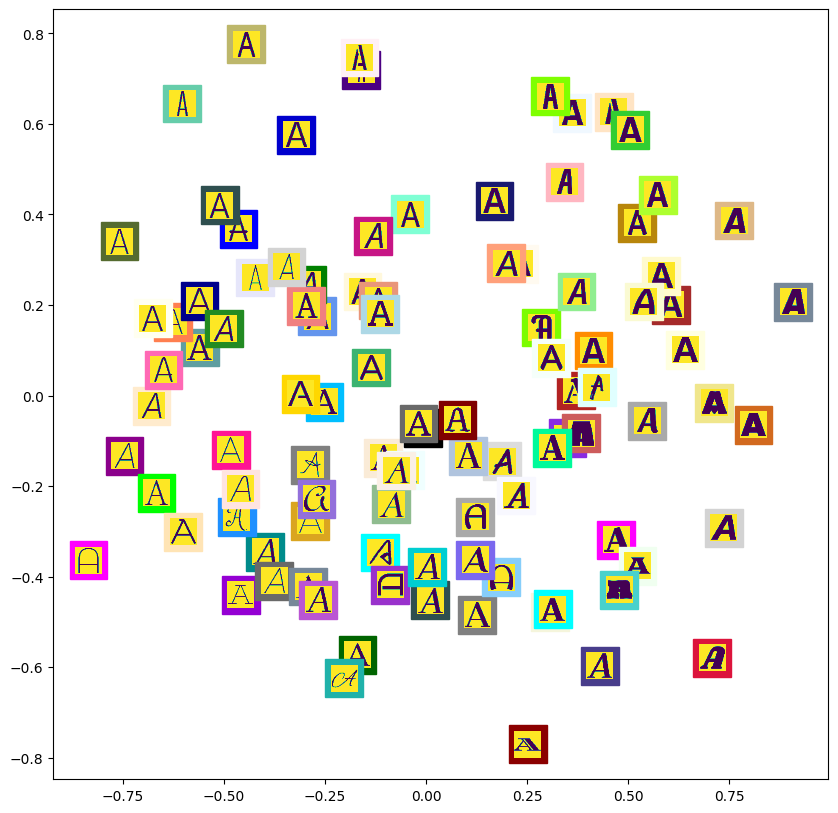

[0.11322545 0.09436209 0.09237666]


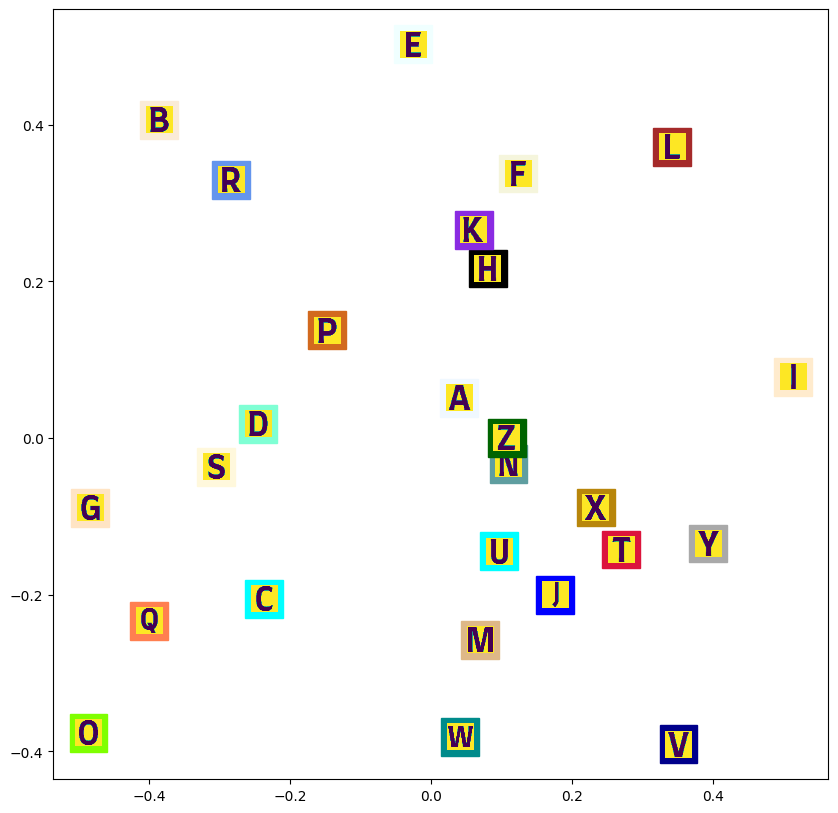

In [23]:
# style emb distribution
b = 100
color = list(matplotlib.colors.CSS4_COLORS.values())
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style, img_list = [], []
for i in range(b):
    img_list.append(d[26*i][0][0])
    style.append(d[26*i][2])
style = torch.tensor(style, device=device, dtype=torch.long)
color_list = [color[s] for s in style]

style_emb = model.style_emb(style)
style_emb = model.style_mlp(style_emb)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(style_emb.cpu().detach().numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

fig, ax = plt.subplots(figsize=(10,10))
imscatter(x, y, img_list, _ax=ax,zoom=0.3, color=color_list)
ax.plot(x,y,'ko',alpha=0.)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_style_emb_distribution.png")
plt.show()

# class emb distribution
b = 26
color = list(matplotlib.colors.CSS4_COLORS.values())
style = torch.full((b,), 0, device=device, dtype=torch.long)
classes, img_list = [], []
for i in range(b):
    img_list.append(d[i][0][0])
    classes.append(d[i][1])
classes = torch.tensor(classes, device=device, dtype=torch.long)
color_list = [color[c] for c in classes]

class_emb = model.classes_emb(classes)
class_emb = model.classes_mlp(class_emb)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(class_emb.cpu().detach().numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

fig, ax = plt.subplots(figsize=(10,10))
imscatter(x, y, img_list, _ax=ax,zoom=0.3, color=color_list)
ax.plot(x,y,'ko',alpha=0.)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_classes_emb_distribution.png")
plt.show()

# 生成画像のL1